/home/bcrp56/.local/lib/python3.8/site-packages/nbodykit/cosmology/power/linear.py:228: FutureWarning: NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'
  warnings.warn("NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'", FutureWarning)
[ 000001.43 ]   0: 04-23 13:19  LogNormalCatalog INFO     Growth Rate is 0.677297
[ 000001.43 ]   0: 04-23 13:19  LogNormalCatalog INFO     Generating whitenoise
[ 000004.44 ]   0: 04-23 13:19  LogNormalCatalog INFO     Write noise generated
[ 000005.75 ]   0: 04-23 13:19  LogNormalCatalog INFO     Displacement computed in fourier space
[ 000006.30 ]   0: 04-23 13:19  LogNormalCatalog INFO     Overdensity computed in configuration space: std = 1.3552231799794863
[ 000008.00 ]   0: 04-23 13:19  LogNormalCatalog INFO     Displacement computed in configuration space: std = [4.814462435018889, 4.811233552035936, 4.900045176706501]
[ 000008.01 ]   0: 04-23 13:19  LogNormalCatalog INFO     gaus

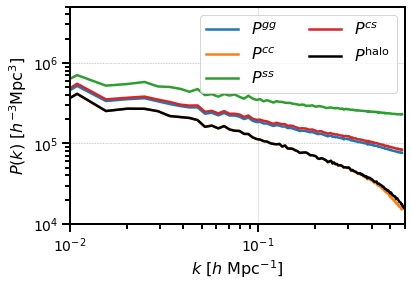

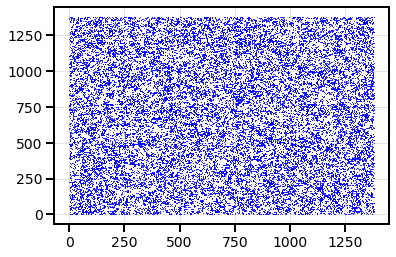

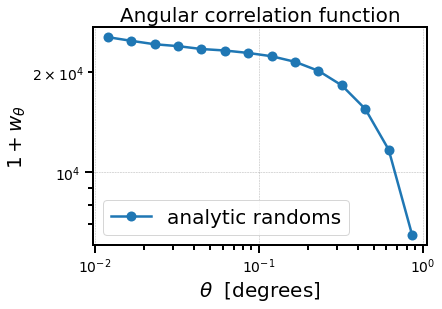

In [1]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

import scipy.interpolate as spi

import numpy as np

from astropy.coordinates import cartesian_to_spherical

from halotools.mock_observables import ra_dec_z
from halotools.mock_observables import mock_survey
from halotools.mock_observables import angular_tpcf


import matplotlib.pyplot as plt
plt.style.use(style.notebook)
setup_logging()

################--Setting up Constants--################
redshift = 0.3
cosmo = cosmology.Planck15
Plin = cosmology.EHPower(cosmo, redshift)

################--Getting the HODCatalog--##############

cat = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=1380., Nmesh=256, bias=2.0, seed=42)
#friend of friends algorithm to identify halos by grouping together clumps with n > nmin particles at a distance of 0.2 times greater than that of the mean seperation of particles
fof = FOF(cat, linking_length=0.2, nmin=5)
#now must assign a mass to each particle (10^12 [M_sun/h]) for use with HODCatalog (HOD = Halo Occupation Distribution)
halos = fof.to_halos(cosmo=cosmo, redshift=redshift, particle_mass=1e12, mdef='vir') #vir means the mass column should be the virial mass
#HODCatalog was changed replaced with the populate function
hod = halos.populate(Zheng07Model,seed=42)

################--Looking at the Power Spectra--########
#this will look at the power spectra of {FOF halos, all galaxies, centrals, satellites, and cross power between centrals and satellites}

cent_idx = hod['gal_type']==0  #gives centrals
sat_idx = hod['gal_type']==1  #gives satellites

cents = hod[cent_idx]
sats = hod[sat_idx]

halo_power = FFTPower(halos, mode='1d', Nmesh=512) #FOF halos
gal_power = FFTPower(hod, mode='1d', Nmesh=256) #all glaxies
cen_power = FFTPower(cents, mode='1d', Nmesh=256) #centrals
sat_power = FFTPower(sats, mode='1d', Nmesh=256) #setellites
cen_sat_power = FFTPower(cents, second=sats, mode='1d', Nmesh=256) #cross b/w centrals and satellites

################--Plotting the Power Spectra--##########

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
labels = [r"$P^{gg}$", r"$P^{cc}$", r"$P^{ss}$"]
for i, r in enumerate([gal_power, cen_power, sat_power]):
    Pk = r.power
    plt.loglog(Pk['k'], Pk['power'].real-Pk.attrs['shotnoise'], label=labels[i]) #'shotnoise' refers to the poisson shot noise which needs to be subtracted off

Pk = cen_sat_power.power
ax.loglog(Pk['k'], Pk['power'].real, label=r"$P^{cs}$")

Phalo = halo_power.power
ax.loglog(Phalo['k'], Phalo['power'].real-Phalo.attrs['shotnoise'], c='k', label=r"$P^\mathrm{halo}$")

# add a legend and axis labels
ax.legend(loc=0, ncol=2)
ax.set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax.set_ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
ax.set_xlim(0.01, 0.6)
ax.set_ylim(1e4, 5e6)

################--Angular Correlation Function--#########

rp_bins = np.logspace(-1,1,10)
#Getting the data from hod to be used with numpy for other calculations
x = hod.compute(hod['x'])
y = hod.compute(hod['y'])
z = hod.compute(hod['z'])

vx = hod.compute(hod['vx'])
vy = hod.compute(hod['vy'])
vz = hod.compute(hod['vz'])

coords = np.vstack((x,y,z)).T
velocities = np.vstack((vx,vy,vz)).T

#I tried to do this in Equitorial Coordinates since that is what the funciton expects but I had a lot of trouble getting the coordinates in that form so I ended up just converting them to spherical and passing in the angular part of the data (code is left in as comments in case I want to look back at it and try and figure it out)

#Note to self: Using Equitorial Coords with dec(lines of declination) and ra(lines of right ascension) if forget: https://astronomy.swin.edu.au/cosmos/E/Equatorial+Coordinate+System

#from halotools.empirical_models import PrebuiltSubhaloModelFactory
#from halotools.sim_manager import CachedHaloCatalog
#halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0)

#model = PrebuiltSubhaloModelFactory('behroozi10')
#model.populate_mock(halocat)
#r = np.sqrt(coords[:,0]**2 + coords[:,1]**2 + coords[:,2]**2)
#keep = r<model.mock.Lbox
#ra_init, dec_init, z = mock_survey.ra_dec_z(coords, velocities)
#ra = np.degrees(ra_init[keep])
#dec = np.degrees(dec_init[keep])

#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
#ax.plot(ra,dec,'.',color='blue',ms=2.0)

#plotting just x and y coordinates to see what hod looks like in terms of positions
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(x,y,'.',color='blue',ms=2.0)

#Setting up sherical coords so that I can use theta and phi since I couldn't get ra and dec to work
sphere_coords = cartesian_to_spherical(x,y,z)
theta = sphere_coords[1:]
phi = sphere_coords[2:]
angular = np.vstack((theta,phi)).T
theta_bins = np.logspace(-2,0,15)
cen_theta_bins = (theta_bins[:-1]+theta_bins[1:])/2.0
w_theta = angular_tpcf(angular, theta_bins, num_threads='max')
print(w_theta)

fig = plt.figure(figsize=(6,4))
ax2 = fig.add_subplot(111)
ax2.plot(cen_theta_bins,1.0+w_theta,'o-', label='analytic randoms')
ax2.loglog()
ax2.set_ylabel(r'$1+w_{\theta}$', fontsize=20)
ax2.set_xlabel(r'$\theta$  $[{\rm degrees}]$', fontsize=20)
ax2.set_title('Angular correlation function', fontsize=20)
ax2.legend(loc='best', fontsize=20)




